# Distributional Analysis

Distributional analysis is a term I coined for a very simple yet powerful way of analyzing datasets. It means that you think of the dataset as a distribution within a large multidimensional space, which you then can examine through its marginal statistics in any two-dimensional subspace.

The best way to understand this is through examples. So let's turn our attention to exploring a dataset of freely-drifting subsurface oceanographic floats.  These instruments record latitude, longitude, and temperature as they drifter around with the currents at more-or-less fixed pressure levels. You'll need to download "floats.nc" from [my web site](http://www.jmlilly.net/data.html).  (This is included in the full distribution of the course materials.)

We'll be using the Python packages Numpy, Matplotlib, Scipy, and Cartopy. You can find more about those here:

https://numpy.org    
https://matplotlib.org   
https://www.scipy.org   
https://scitools.org.uk/cartopy 

In particular, here is a nice tutorial on Cartopy, a mapping package for Python:  
https://coderzcolumn.com/tutorials/data-science/cartopy-basic-maps-scatter-map-bubble-map-and-connection-map

Many thanks to Jan-Adrian Kallmyr for helping with translating the Matlab tutorial into Python.

To start we'll import the required Python packages.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings  #ignore warnings for readability
warnings.filterwarnings('ignore')

In [2]:
datadir = "/Users/lilly/Desktop/Dropbox/Python/time_series_analysis/data/"  #path to the directory where you've put floats.nc
floats = xr.open_dataset(datadir + "floats.nc")
floats

<xarray.Dataset>
Dimensions:  (segment: 3091, column: 1267240)
Dimensions without coordinates: segment, column
Data variables:
    expid    (segment) float64 ...
    typeid   (segment) float64 ...
    id       (segment) float64 ...
    num      (column) float64 ...
    lat      (column) float64 ...
    lon      (column) float64 ...
    u        (column) float64 ...
    v        (column) float64 ...
    p        (column) float64 ...
    t        (column) float64 ...
    filled   (column) float64 ...
Attributes:
    title:      FLOATS.NC subsurface float dataset
    link:       http://www.aoml.noaa.gov/phod/float_traj/data.php
    about:      For more information, see ABOUT_FLOATS.M.
    note:       In Matlab, try 'ncload floats' using jLab routine ncload.
    creator:    J. M. Lilly
    timestamp:  13-Jan-2019 16:46:27

We see that we have a data set with many different variables and two dimensions: column and segment.  The column dimension has all data points from all float trajectories concatenated together, with nans marking the tails, while the segment dimension has one element per float trajectory (e.g. float id number).

## Exploring Floats.nc

Let's make a basic plot of floats.nc.  We will loop over all of the trajectories in order to plot each trajectory with a different color.

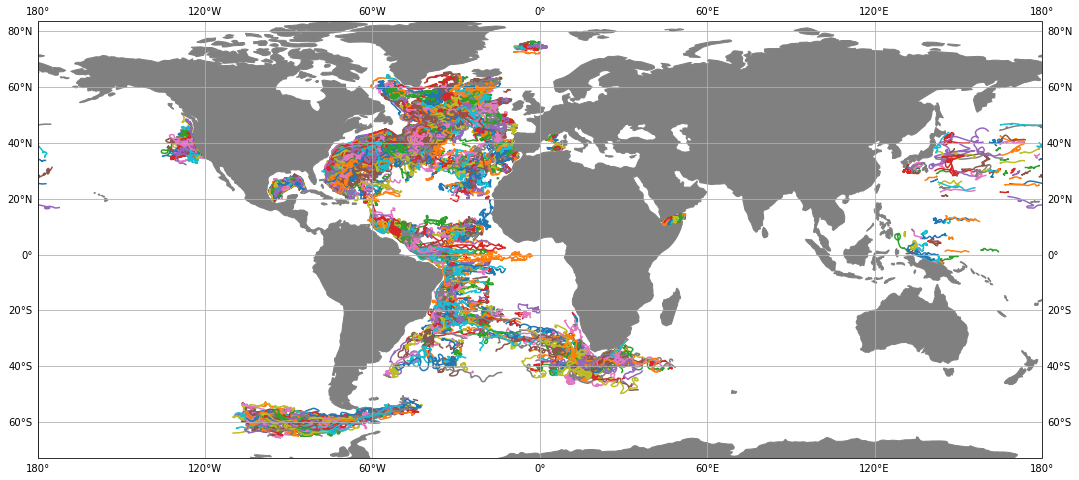

In [3]:
lon = floats.lon.values
lat = floats.lat.values 

figsize=np.array([18, 12]);
projection=ccrs.PlateCarree();
#some other projections we might try
#projection=ccrs.Robinson();
#projection=ccrs.LambertCylindrical();

#for future reference, define a function to set up our map
def map_setup(figsize,projection):
   fig = plt.figure(figsize=figsize)
   ax = fig.add_subplot(projection=projection)
   ax.add_feature(cfeature.LAND, facecolor='grey')
   ax.gridlines(draw_labels=True)  
   return fig, ax

fig, ax = map_setup(figsize,projection) 

#find the head (a) and tail (b) of each nan-separated segment, excluding the nans
b = np.argwhere(np.isnan(lat)) - 1
a = np.roll(b,1)+2

#set lon to nan when we jump across the dateline, for plotting purposes
lon_nojumps = lon
lon_nojumps[np.abs(lon-np.roll(lon, -1))>10] = np.nan; #nan for lon jumps > 10 degrees

#plot each float trajectory with its own color ... this takes a minute
for n in range(0,np.size(floats.id)):
     #index into values belonging to the nth trajectory
     index = np.arange(a.item(n),b.item(n))  
     #note you can't use a[n],b[n] because those are length 1 arrays, not scalars
     if index.size > 0:
         plt.plot(lon_nojumps[index], lat[index],transform=ccrs.PlateCarree())
         #The "transform = ccrs.PlateCarree()" specifies that the data are given as latitude and longitude
         #By default, the data is assumed to be in the same projection as that of the axis object

## Two-Dimensional Histograms

Now we're going to start exploring this dataset as a distribution.  The first step is to plot the two dimensional histogram of observation locations in latitude--longitude space. 

In the code below, stats.binned_statistic_2d() is the central function, which we can use to compute a number of different statistics. First we are interested in the number of observations in each bin specified by statistic="count".  The third argument, where observation values would normally go, can be "None" in such a case.

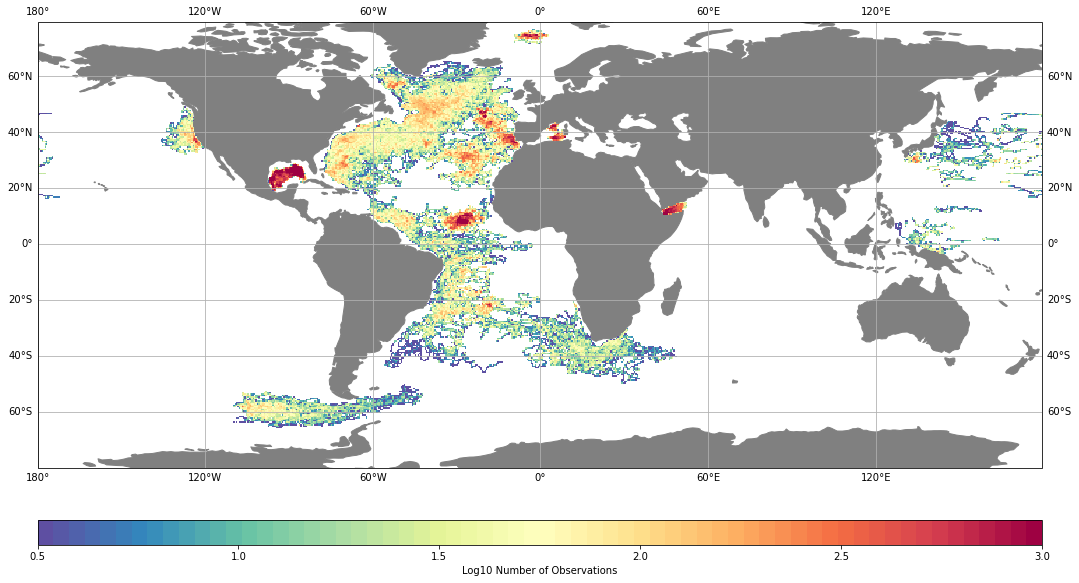

In [4]:
#cmap = plt.cm.get_cmap("plasma_r", 40)
#some other colormaps.  Note that the "_r" reverses the map
#cmap = plt.cm.get_cmap("magma_r", 40)
#cmap = plt.cm.get_cmap("inferno_r", 40)
#cmap = plt.cm.get_cmap("viridis_r", 40)
#cmap = plt.cm.get_cmap("RdYlBu_r", 64)
cmap = plt.cm.get_cmap("Spectral_r", 64)


fig, ax = map_setup(figsize,projection) 

dlatlon = 0.5
lonbins = np.arange(-180, 180, dlatlon)
latbins = np.arange(-80, 80, dlatlon)

hist = stats.binned_statistic_2d(lat, lon, None, bins=[latbins, lonbins], statistic="count")  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf

image = plt.pcolormesh(lonbins, latbins, np.log10(hist.statistic), cmap=cmap, shading="flat", transform=ccrs.PlateCarree()) 
plt.clim(0.5, 3) 

fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.08, label="Log10 Number of Observations")   

We see that the observation density is high throughout the Atlantic, and is particuarly high in the Gulf of Mexico, the Gulf of Aden adjacent to the Red Sea, and several other hot spots.

## Two-Dimensional Means and Standard Deviations

Another important statistic we can plot is the speed of the mean flow. Along the way we'll extract u and v for future reference.  Note that we can just use stats.binned_statistic_2d with the flag statistic = "mean".   

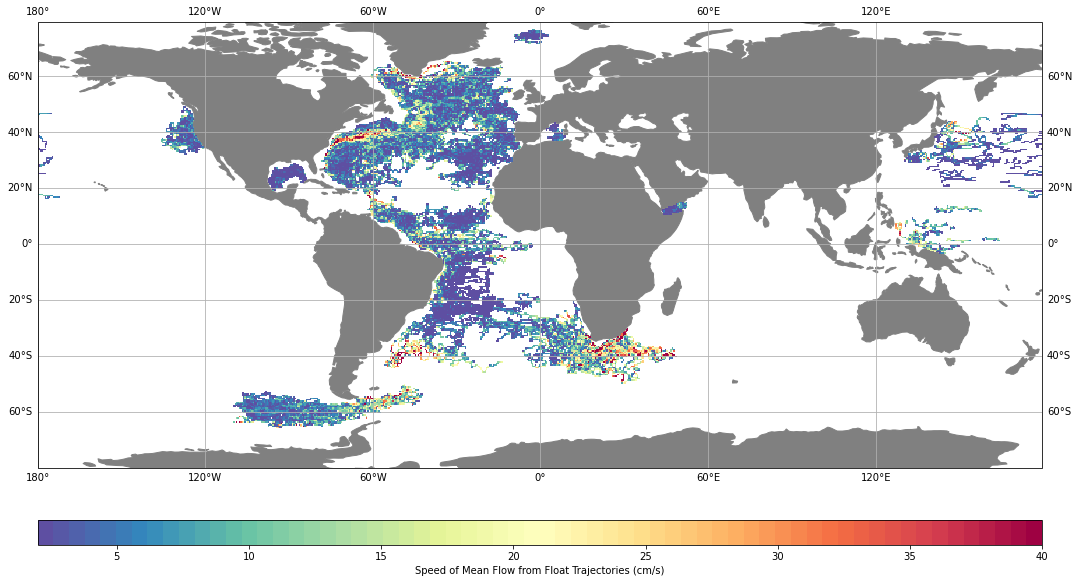

In [5]:
u = floats.u.values
v = floats.v.values

ubar = stats.binned_statistic_2d(lat, lon, u, bins=[latbins, lonbins], statistic="mean")  
vbar = stats.binned_statistic_2d(lat, lon, v, bins=[latbins, lonbins], statistic="mean")  

meanflow = np.sqrt(ubar.statistic ** 2 + vbar.statistic ** 2)

fig, ax = map_setup(figsize,projection) 

image = plt.pcolormesh(lonbins, latbins, meanflow, cmap=cmap, shading="flat", transform=ccrs.PlateCarree()) 
plt.clim(2, 40) 

fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.08, label="Speed of Mean Flow from Float Trajectories (cm/s)")  

In the North Atlantic, we see that the mean flow is large over the Gulf Stream, as expected, as well as around the periphery of Greenland where there is a known boundary current.  The high velocities in the South Atlantic and North Pacific correspond to areas where the preceding map showed a low sample density, and therefore, the mean flows in these areas are probably not well resolved.

Another interesting statistics is the velocity standard deviation.  To compute this we first use stats.binned_statistic_2d to find the standard deviation of u and v separately.  

Here we run into a peculiarity in stats.binned_statistic_2d.  While we should be able to simply run this function with the statistic = "std", for some reason this is insanely slow---nearly a minute and a half on my machine versus less than a second for statistic = "mean".   

This is a [known issue](https://github.com/scipy/scipy/issues/11468) and arises because the code implementation is meant to be accurate for problematic cases that we're probably never going to encounter.  Fortunately, there is a simple workaround as explained below. 

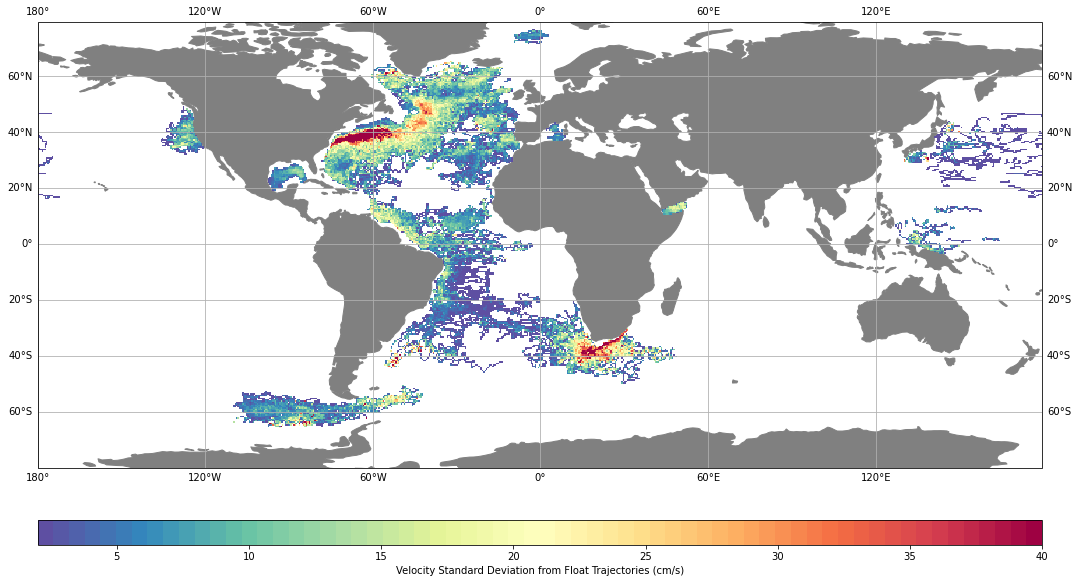

In [6]:
#here is what we would like to do ... but it runs far too slowly
#ustd = stats.binned_statistic_2d(lat, lon, u, bins=[latbins, lonbins], statistic="std")  
#vstd = stats.binned_statistic_2d(lat, lon, v, bins=[latbins, lonbins], statistic="std")  
#std = np.sqrt(ustd.statistic ** 2 + vstd.statistic ** 2)
#std[std == 0] = np.nan #set zero values of standard deviation to nans

#Instead we make use of the identity <(x - <x>)^2> = <x^2> - <x>^2 for x=u and x=v

ubar = stats.binned_statistic_2d(lat, lon, u, bins=[latbins, lonbins], statistic="mean")  
vbar = stats.binned_statistic_2d(lat, lon, v, bins=[latbins, lonbins], statistic="mean")  

u2bar = stats.binned_statistic_2d(lat, lon, u ** 2, bins=[latbins, lonbins], statistic="mean")  
v2bar = stats.binned_statistic_2d(lat, lon, v ** 2, bins=[latbins, lonbins], statistic="mean")  

ustd = np.sqrt(np.abs(u2bar.statistic - ubar.statistic ** 2))  #the abs prevents imaginary parts from numerical noise
vstd = np.sqrt(np.abs(v2bar.statistic - vbar.statistic ** 2))  #the abs prevents imaginary parts from numerical noise

std = np.sqrt(ustd ** 2 + vstd ** 2)
std[std == 0] = np.nan #set zero values of standard deviation to nans

fig, ax = map_setup(figsize,projection) 

image = plt.pcolormesh(lonbins, latbins, std, cmap=cmap, shading="flat", transform=ccrs.PlateCarree()) 
plt.clim(2, 40) 

fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.08, label="Velocity Standard Deviation from Float Trajectories (cm/s)")  

Here, we're using the same color axis as in the previous plot to make these two quantities directly comparable.  Note that the area of high velocity variance in the vicinity of the Gulf Stream appears broader than the area where the mean flow is large in magnitude.  This is an intuitive result because the Gulf Stream is characterized by meanders about its mean position.  Also in the plot, a high variance region south of Africa, associated with the Agulhas current, appears more clearly than was seen in the mean flow map.

## Two-Dimensional Means of Further Quantities

There are less obvious aspects of the data that we can also examine through the use of plots of its statistics in two dimensions.  The floats are not all at the same vertical level. Rather, they are set to observe a target pressure level, which can be approximated as a depth level; this pressure level tends to wander a bit with time as temperature and salinity properties of the water column change.  

Thus the above maps of velocity have mixed up measurements from many different vertical levels.  To get an idea of the spatial distribution of the float sampling with respect to pressure, we can look at the mean *pressure* rather than the mean *velocity*.

Note that in the following we make use of the approximation that 1 decibar of pressure is about 1 m of depth in the ocean.

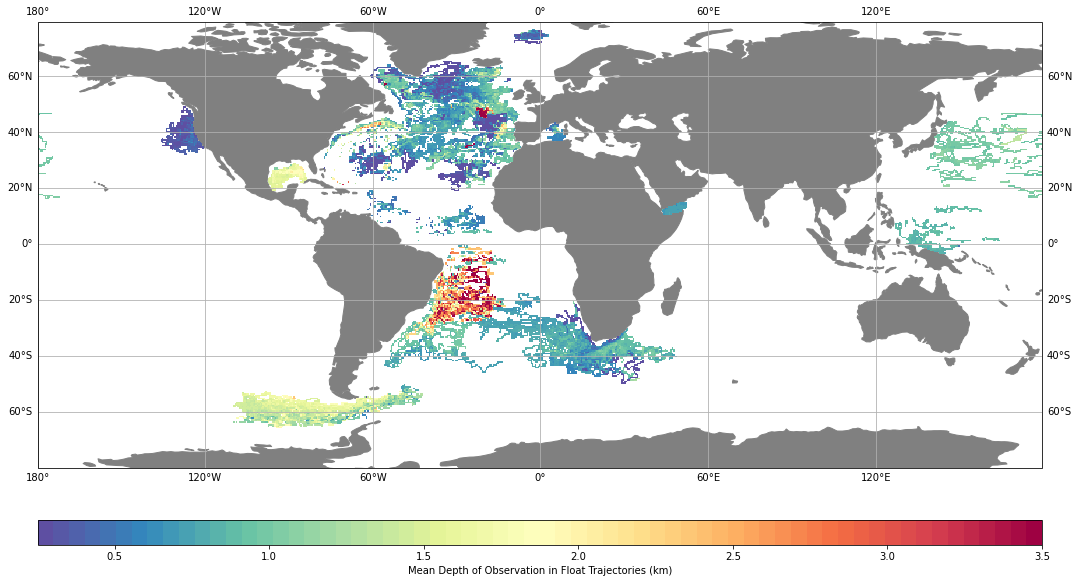

In [7]:
p = floats.p.values / 1000 #convert dbar of pressure into km depth

fig, ax = map_setup(figsize,projection) 

meanp= stats.binned_statistic_2d(lat, lon, p, bins=[latbins, lonbins], statistic="mean")  
image = plt.pcolormesh(lonbins, latbins, meanp.statistic, cmap=cmap, shading="flat", transform=ccrs.PlateCarree()) 
plt.clim(0.25,3.5) 

fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.08, label="Mean Depth of Observation in Float Trajectories (km)")  

Similarly, we can look at the mean temperature observed by the floats.

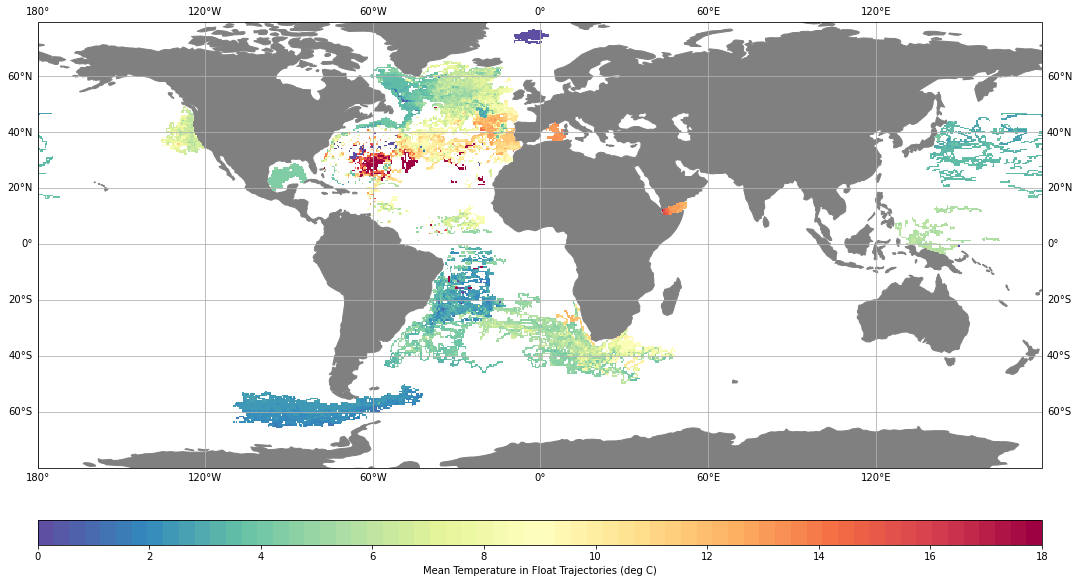

In [8]:
t = floats.t.values 

fig, ax = map_setup(figsize,projection) 

meant= stats.binned_statistic_2d(lat, lon, t, bins=[latbins, lonbins], statistic="mean")  
image = plt.pcolormesh(lonbins, latbins, meant.statistic, cmap=cmap, shading="flat", transform=ccrs.PlateCarree()) 
plt.clim(0,18) 

fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.08, label="Mean Temperature in Float Trajectories (deg C)")  

## Rotating the Distribution

How is the observed temperature distribution related to the observational depths (or pressures) seen in the previous plot?  We can explore this relationship, still using two-dimensional statistics, by changing our perspective and examining the distribution of the data in *pressure and temperature space*.

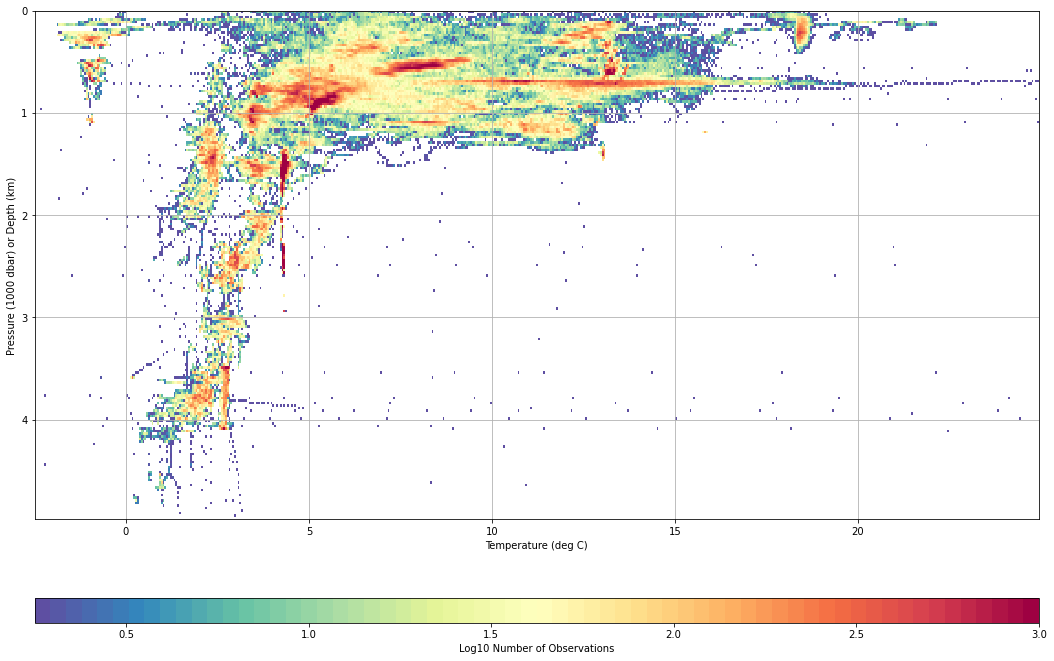

In [9]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()

pbins = np.arange(0, 5, .025)
tbins = np.arange(-2.5, 25, .05)

hist = stats.binned_statistic_2d(p, t, None, bins=[pbins, tbins], statistic="count")  
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf

image = plt.pcolormesh(tbins, pbins, np.log10(hist.statistic), cmap=cmap, shading="flat") 
plt.clim(0.25, 3) 
ax.invert_yaxis()
ax.grid() #add grid lines...  this has to come after plotting for some reason
plt.xlabel("Temperature (deg C)")
plt.ylabel("Pressure (1000 dbar) or Depth (km)")
fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.12, label="Log10 Number of Observations")   

This very beautiful plot shows how the float measurements are sampling the basic temperature structure of the ocean.  A number of interesting features are apparent. 

What is important to note is that it is essentially just the first two-dimensional statistic that we plotted earlier---the number of observations in bins.  However, rather than plotting the number of samples in lat--lon space, here we are using temperature--pressure space.  

When you have an object in three dimensions, its shadow changes as you rotate it.  The shadow is the projection of the higher-dimensional object into two-dimensional space.  

Our dataset is a distribution of values in multiple dimensions---latitude, longitude, pressure, temperature, u velocity, v velocity, speed, data, time of year, etc.---and so can be thought of as a multidimensional object.  When we plot its distribution in different two-dimension spaces, it is like rotating this multidimensional object to look at its shadows.  

The data itself is a distribution in a high dimensional space that we can't visualize directly, although we can picture it abstractly.  In statistical terms, collapsed statistics---such as the latitude and longitude distribution for all values of the other parameters---are known as *marginal statistics*.

This very simple idea is what is meant by distributional analysis. We are rotating the data and looking at its statistics in different two-dimensional subspaces.  

We'll show a few more final examples.  The temperature--pressure distribution certainly varies with latitude.  Let's look at this in two different ways, firstly through examining the mean latitude magnitude, abs(lat), as a function of the temperature--pressure plane. 


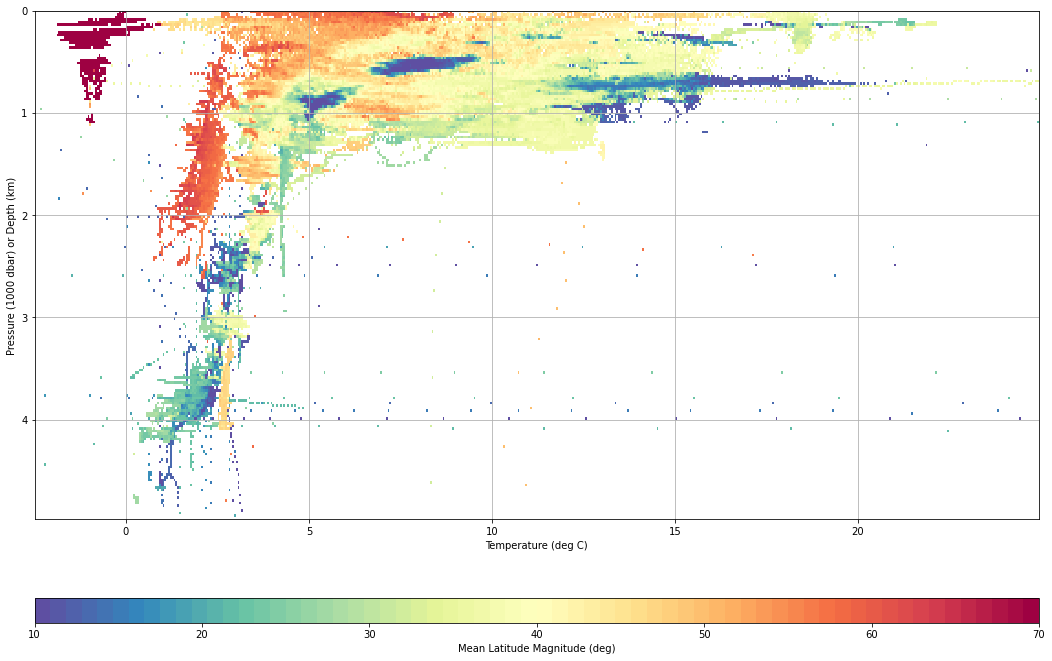

In [10]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()

meanlat = stats.binned_statistic_2d(p, t, np.abs(lat), bins=[pbins, tbins], statistic="mean")

image = plt.pcolormesh(tbins, pbins, meanlat.statistic, cmap=cmap, shading="flat") 
plt.clim(10, 70) 
ax.invert_yaxis()
ax.grid() #add grid lines...  this has to come after plotting for some reason
plt.xlabel("Temperature (deg C)")
plt.ylabel("Pressure (1000 dbar) or Depth (km)")
fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.12, label="Mean Latitude Magnitude (deg)")   

Here we see, unsurprisingly, that temperatures below zero tend to occur at high latitudes, while warmer temperatures tend to occur at lower latitudes.  A number of low-latitude blobs stand out that correspond to regions of high sampling density from the previous plot. 

There are three dimensions being visualized in this plot---temperature, pressure, and latitude.  Let's rotate that three dimensional distribution, and look at it from another angle.

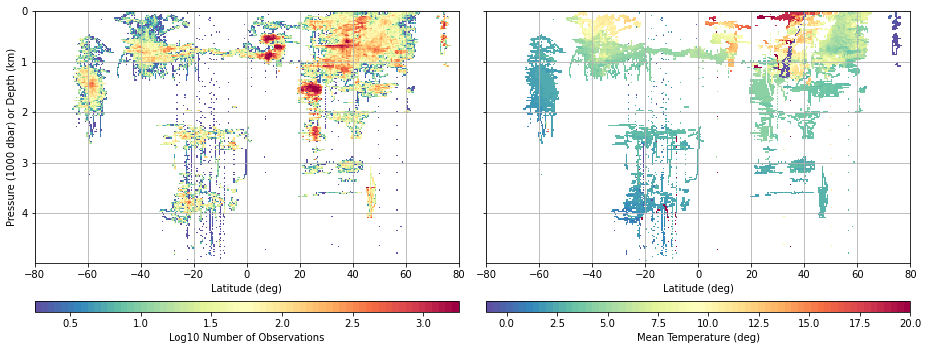

In [28]:
fig,ax = plt.subplots(1,2,figsize=(13,5),sharey=True)

hist = stats.binned_statistic_2d(p, lat, None, bins=[pbins, latbins], statistic="count")  
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf

plt.sca(ax[0])
image = plt.pcolormesh(latbins, pbins, np.log10(hist.statistic), cmap=cmap, shading="flat") 
plt.clim(0.25, 3.25) 
ax[0].invert_yaxis()
ax[0].grid() #add grid lines...  this has to come after plotting for some reason
plt.xlim(-80,80)
plt.xlabel("Latitude (deg)")
plt.ylabel("Pressure (1000 dbar) or Depth (km)")
fig.colorbar(image, ax=ax[0], orientation='horizontal', fraction=0.1, aspect=40, pad=0.12, label="Log10 Number of Observations")   

plt.sca(ax[1])
meant = stats.binned_statistic_2d(p, lat, t, bins=[pbins, latbins], statistic="mean") 
image = plt.pcolormesh(latbins, pbins, meant.statistic, cmap=cmap, shading="flat") 
plt.clim(-1,20) 
ax[1].grid() #add grid lines...  this has to come after plotting for some reason
plt.xlim(-80,80)
plt.xlabel("Latitude (deg)")
fig.colorbar(image, ax=ax[1], orientation='horizontal', fraction=0.1, aspect=40, pad=0.12, label="Mean Temperature (deg)"); 

plt.tight_layout()   

The left-hand plots shows the distribution of observations on the latitude--pressure plane, while the right-hand plot shows the average temperature on this plane.  If you compare with the previous plots on the temperature--pressure plane, you can match up a number of clouds of observations.  For example, look between 0 and 20 degrees latitude in the above plot and see what this corresponds to on the temperature--pressure plane.

Using distributional analysis, we can rapidly explore datasets now matter how they are organized.  With a little imagination, patterns hidden in the data can begin to emerge, helping us determine what our next steps should be.  I find this approach to be remarkably powerful, and it is normally my first step in diving into a new dataset.

A few ideas that we didn't explore here, but that are often useful, are (i) using date, time of year, or time of day, as one of our dimensions, (ii) using other statistics, such as the median or high-order statistics like skewness and kurtosis, and (iii) using frequency, arising from the spectral analysis methods we'll explore later, as one of the dimensions.

# The End